<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.ParisHousingPrices/blob/main/0_baseline_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This file does NOT contain high quality code! This file is dedicated to the skill of writing pipelines quickly

# Setup

In [1]:
from google.colab import drive
# Datasets
import pandas as pd
# Numerics
import numpy as np
# Plotting
import matplotlib.pyplot as plt
# Preprocessing & pipelines
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# Data management
from sklearn.model_selection import train_test_split
# Other
import os

pd.set_option('display.max_columns', None)

In [2]:
%%capture
GIT_DOWNLOAD_PATH = 'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'
FILES_LIST = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py',
    'model.py'
]
GDRIVE_PATH = '/content/gdrive/MyDrive/'
PREPROC_TRIAL = 1
MODELS_TRIAL = 1
COMPETITION_PATH = GDRIVE_PATH + 'ML/Competitions/10.ParisHousePrices/'
# --------------------------------------------------
try:
    from nbpep8.nbpep8 import pep8
except ModuleNotFoundError:
    !pip install pycodestyle
    !pip install --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8
# ---------------------------------------
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}
url_dict = {file: GIT_DOWNLOAD_PATH + file for file in FILES_LIST}
print('a')
download_files(url_dict)
# ---------------------------------------
import importlib
import path_manager
import sklearn_utils
import sklearn_transformers
import model
def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)
MODULES_LIST = [
    path_manager,
    sklearn_utils,
    sklearn_transformers,
    model
]
reload_all(MODULES_LIST)
# ---------------------------------------
from path_manager import PathManager
from model import Model
from sklearn_utils import nan_statistics
from sklearn_utils import boxplot_regression
from sklearn_utils import get_correlated_attributes
from sklearn_utils import visualize_datasets_distributions
from sklearn_transformers import ColumnDropper
from sklearn_transformers import LogTransformer
# ---------------------------------------
from google.colab import drive
drive.mount('/content/gdrive')
manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()


# Download the data

In [3]:
df_train = pd.read_csv(manager.train_path, index_col='id')
df_submission = pd.read_csv(manager.test_path, index_col='id')

df_train.size, df_submission.size

assert set(df_train.columns) - set(df_submission.columns) == {'price'}

- For now, we will look only at the train dataset

# Quick look at the data

In [4]:
df_submission.head(3)

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
id,,,,,,,,,,,,,,,,
22730,47580,89,0,1,8,54830,5,3,1995,0,0,6885,8181,241,0,8
22731,62083,38,0,0,87,8576,10,3,1994,1,1,4601,9237,393,1,4
22732,90499,75,1,1,37,62454,9,6,1997,0,1,7454,2680,305,0,2


In [5]:
df_train.head(3)

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
id,,,,,,,,,,,,,,,,,
0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2
1,95145,60,0,1,60,34773,1,4,2000,0,1,729,4496,277,0,6,9519958.0
2,92661,45,1,1,62,45457,4,8,2020,1,1,7473,8953,245,1,9,9276448.1


In [6]:
df_train.columns

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price'],
      dtype='object')

In [7]:
df_train.dtypes

squareMeters           int64
numberOfRooms          int64
hasYard                int64
hasPool                int64
floors                 int64
cityCode               int64
cityPartRange          int64
numPrevOwners          int64
made                   int64
isNewBuilt             int64
hasStormProtector      int64
basement               int64
attic                  int64
garage                 int64
hasStorageRoom         int64
hasGuestRoom           int64
price                float64
dtype: object

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22730 entries, 0 to 22729
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       22730 non-null  int64  
 1   numberOfRooms      22730 non-null  int64  
 2   hasYard            22730 non-null  int64  
 3   hasPool            22730 non-null  int64  
 4   floors             22730 non-null  int64  
 5   cityCode           22730 non-null  int64  
 6   cityPartRange      22730 non-null  int64  
 7   numPrevOwners      22730 non-null  int64  
 8   made               22730 non-null  int64  
 9   isNewBuilt         22730 non-null  int64  
 10  hasStormProtector  22730 non-null  int64  
 11  basement           22730 non-null  int64  
 12  attic              22730 non-null  int64  
 13  garage             22730 non-null  int64  
 14  hasStorageRoom     22730 non-null  int64  
 15  hasGuestRoom       22730 non-null  int64  
 16  price              227

In [9]:
df_train.describe()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
count,2.273000e+04,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,2.273000e+04
mean,4.658622e+04,48.241091,0.475891,0.452750,47.305983,50013.795996,5.585042,5.620766,2008.005059,0.467972,0.460009,5283.646634,5067.981698,530.469644,0.461681,5.153058,4.634457e+06
std,4.952124e+04,28.226428,0.499429,0.497773,47.777207,30006.637729,2.739533,2.713026,118.826777,0.498984,0.498409,3047.084412,3097.347939,274.840604,0.498540,3.055246,2.925163e+06
min,8.900000e+01,1.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1990.000000,0.000000,0.000000,4.000000,1.000000,4.000000,0.000000,0.000000,1.031350e+04
25%,2.039275e+04,25.000000,0.000000,0.000000,25.000000,22936.000000,3.000000,3.000000,2000.000000,0.000000,0.000000,2977.250000,2599.000000,297.000000,0.000000,3.000000,2.041739e+06
50%,4.448400e+04,47.000000,0.000000,0.000000,45.000000,50414.000000,6.000000,6.000000,2006.000000,0.000000,0.000000,5359.000000,4977.000000,515.000000,0.000000,5.000000,4.450823e+06
75%,7.154700e+04,75.000000,1.000000,1.000000,69.000000,76291.000000,8.000000,8.000000,2014.000000,1.000000,1.000000,7746.000000,7652.000000,767.000000,1.000000,8.000000,7.159920e+06
max,6.071330e+06,100.000000,1.000000,1.000000,6000.000000,491100.000000,10.000000,10.000000,10000.000000,1.000000,1.000000,91992.000000,96381.000000,9017.000000,1.000000,10.000000,1.000428e+07


## NAN

In [10]:
from sklearn_utils import nan_report

_ = nan_report(df_train, 0.0)

0 / 17 cols (0.0 %) have nan % > 0.0

Series([], dtype: float64)


- All training data is numeric
- No NAN values

# Split the data

In [11]:
from sklearn.model_selection import train_test_split

TRAINVAL_SIZE = 0.8
TRAIN_SIZE = 0.8
RANDOM_STATE = 42

df_trainval, df_test = train_test_split(
    df_train,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE
)

df_train, df_val = train_test_split(
    df_trainval,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE
)

df_train.size, df_val.size, df_test.size, df_submission.size

(247299, 61829, 77282, 242464)

In [13]:
EXPLORATION_SIZE = 0.01

df_exploration, _ = train_test_split(
    df_train,
    train_size=EXPLORATION_SIZE,
    random_state=RANDOM_STATE
)

df_exploration.size

2465

In [54]:
def X_Y(df, return_y):
    if return_y:
        X=df.loc[:, [c for c in df.columns if c != 'price']]
        y=df[['price']].values.ravel()
    else:
        X = df.loc[:, :]
        y = None
    return X, y

X_train, Y_train = X_Y(df_train, True)
X_val, Y_val = X_Y(df_val, True)
X_test, Y_test = X_Y(df_test, True)
X_exploration, Y_exploration = X_Y(df_exploration, True)

X_submission, _ = X_Y(df_submission, False)

### Verify that the data is from the same distribution

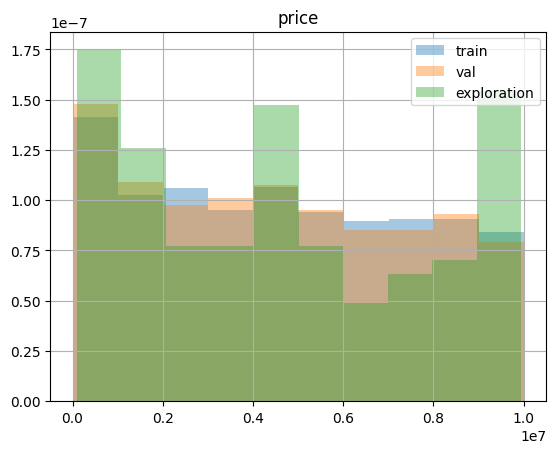

In [56]:
_, ax = plt.subplots()

Y_train.hist(density=True, alpha=0.4, ax=ax, label='train')
Y_val.hist(density=True, alpha=0.4, ax=ax, label='val')
Y_exploration.hist(density=True, alpha=0.4, ax=ax, label='exploration')

ax.legend()

# Data exploration

In [29]:
df_train.numberOfRooms.describe()

count    14547.000000
mean        48.243693
std         28.302032
min          1.000000
25%         25.000000
50%         47.000000
75%         75.000000
max        100.000000
Name: numberOfRooms, dtype: float64

<ipython-input-26-0cee6c3cd648>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  _ = df_exploration.hist(ax=ax)


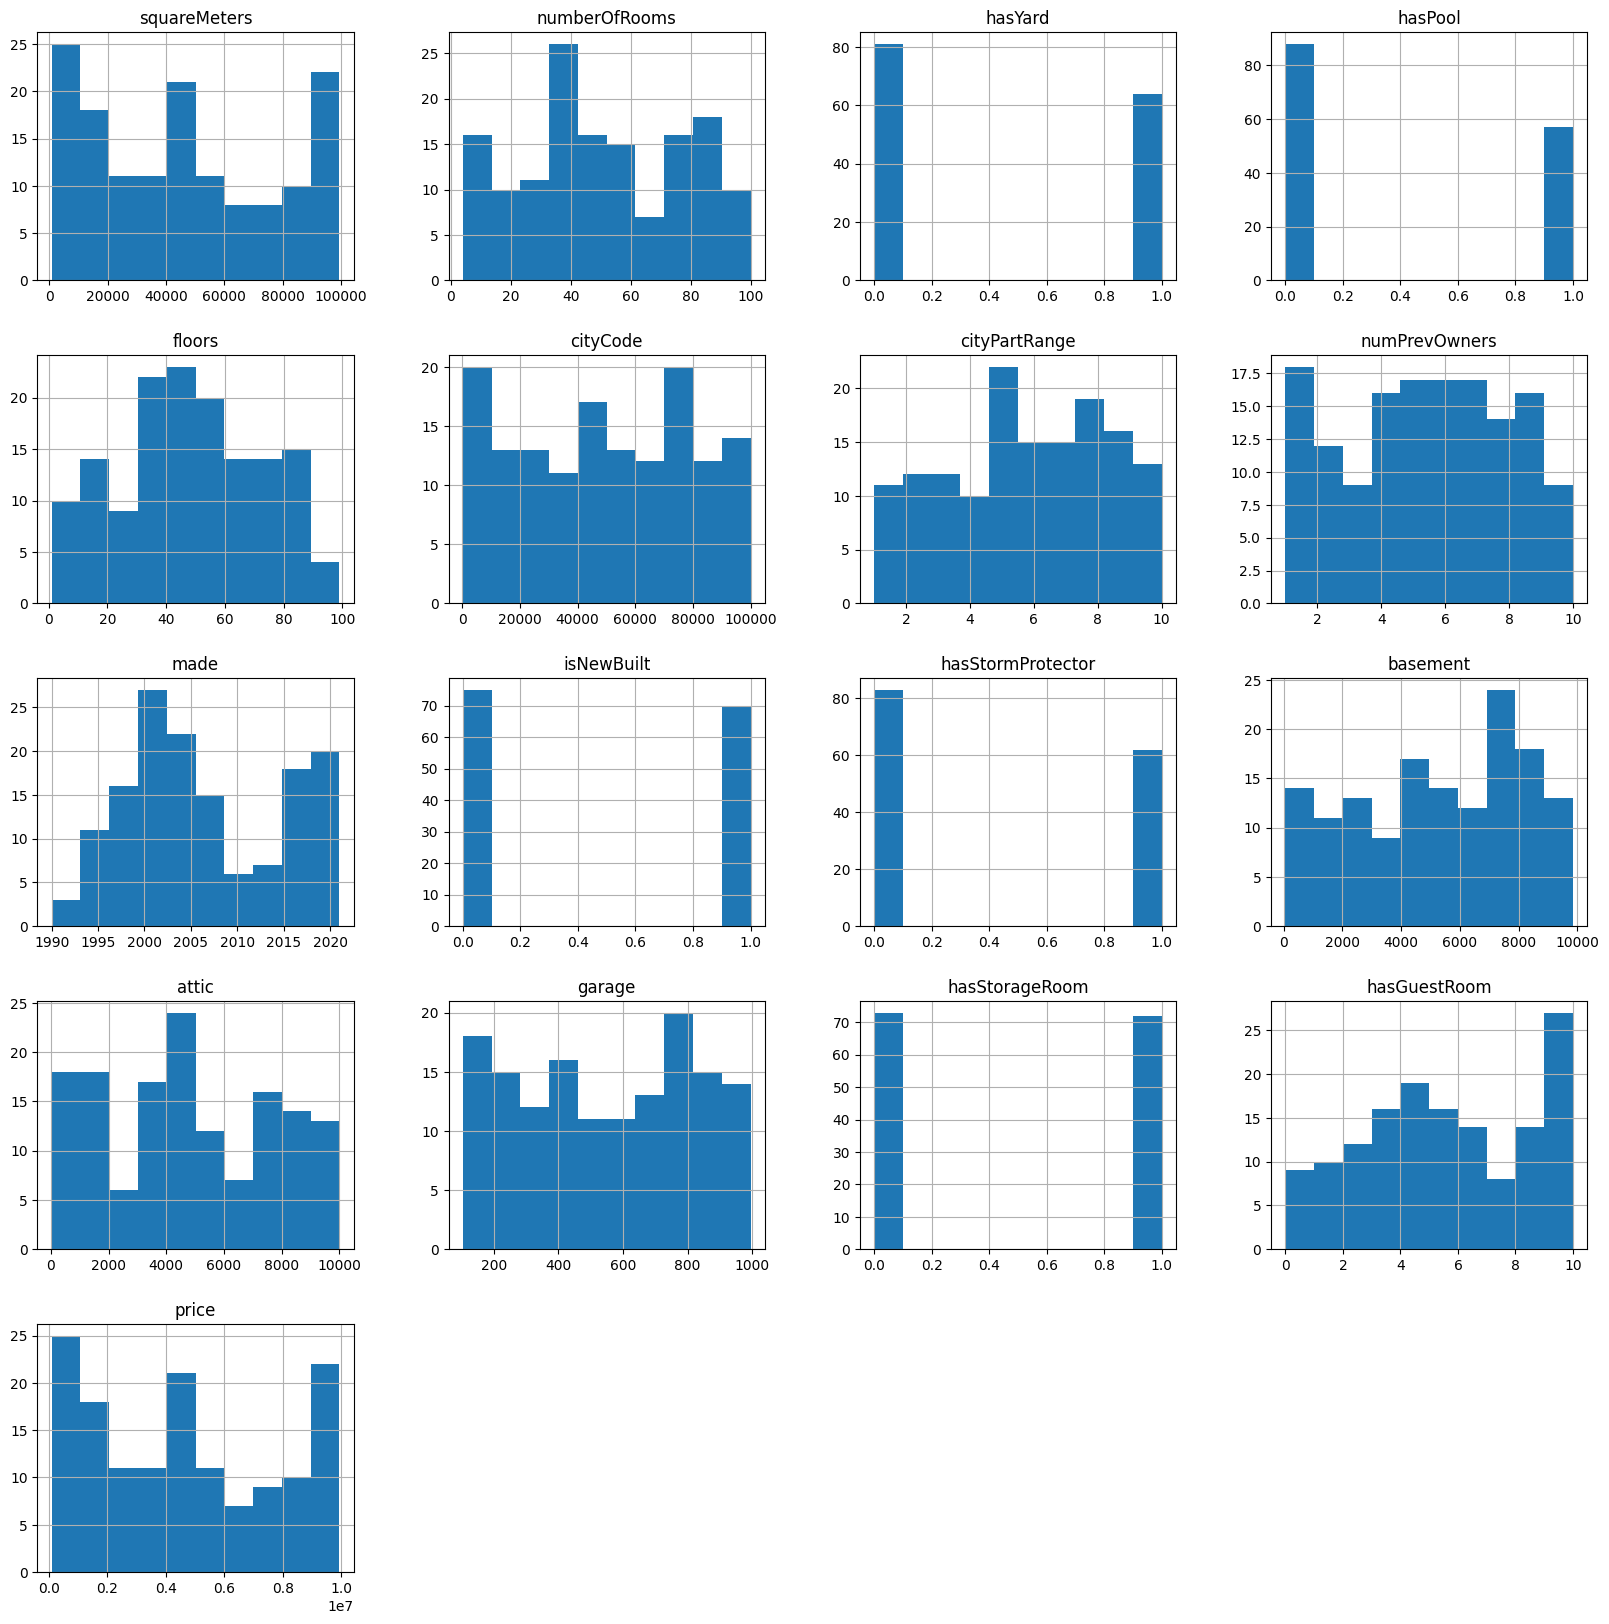

In [26]:
_, ax = plt.subplots(figsize=(20, 20))
_ = df_exploration.hist(ax=ax)

- Yard / Pool / NewBuilt / StormProtector / StorageRoom - > do feature cross for 32 new features
- Add a 'square meters per room' feature
- Map CityCode feature into a category (city center, bad neighbordhood, etc.)

# Preprocessing

## Define preprocessor

In [57]:
from sklearn.compose import ColumnTransformer
# No imputers needed, no NAN columns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


num_columns = df_train.columns.tolist()
bool_columns = ['hasYard', 'hasPool', 'isNewBuilt', 'hasStormProtector', 'hasGuestRoom']

for b in bool_columns:
    num_columns.remove(b)
    assert not b in num_columns
num_columns.remove('price')

assert set(df_train.columns.tolist()) - set(num_columns) - set(bool_columns) == {'price'}

In [58]:
num_pipeline = make_pipeline(
    # imputer is not needed, no NANs
    StandardScaler()
)

# bool_pipeline = make_pipeline(

# )

In [71]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_columns),
    ],
    remainder='passthrough'
)

# Process the data

In [72]:
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)
X_submission_processed = preprocessor.transform(X_submission)

# Create the baseline model

## Random forest

### Build the model

In [75]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [106]:
rf_model = RandomForestRegressor(
    n_estimators=500,
    verbose=1,
    n_jobs=-1,
)
rf_model.fit(X_train_processed, Y_train.values.ravel())

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   40.0s finished


RandomForestRegressor(n_estimators=500, n_jobs=-1, verbose=1)

In [107]:
from sklearn.metrics import mean_squared_error

print(
    mean_squared_error(
        rf_model.predict(X_train_processed),
        Y_train.values.ravel(),
        squared=False
    )
)

print(
    mean_squared_error(
        rf_model.predict(X_val_processed),
        Y_val,
        squared=False
    )
)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    1.3s finished
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


71274.20965020287
5425915.496451376


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


## Randomized search

In [94]:
from sklearn.model_selection import RandomizedSearchCV

rf_randomized = RandomizedSearchCV(
    RandomForestRegressor(),
    param_distributions={
        'n_estimators': np.arange(100, 600),
        'max_depth': [None] + np.arange(1, 17).tolist(),
        'verbose': [1],
        'random_state': [RANDOM_STATE]
    },
    scoring='neg_mean_squared_error',
    n_iter=10,
    verbose=5,
    cv=3
)

In [95]:
rf_randomized_res = rf_randomized.fit(
    X_train_processed,
    Y_train
)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3] END max_depth=5, n_estimators=113, random_state=42, verbose=1;, score=-48566789696.977 total time=   3.4s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3] END max_depth=5, n_estimators=113, random_state=42, verbose=1;, score=-45788066630.915 total time=   2.8s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3] END max_depth=5, n_estimators=113, random_state=42, verbose=1;, score=-38810484211.709 total time=   2.8s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    6.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   13.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3] END max_depth=6, n_estimators=452, random_state=42, verbose=1;, score=-39379787892.239 total time=  13.6s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    6.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   13.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3] END max_depth=6, n_estimators=452, random_state=42, verbose=1;, score=-30090698595.361 total time=  13.5s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    6.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   13.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.4s
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3] END max_depth=6, n_estimators=452, random_state=42, verbose=1;, score=-42178001850.441 total time=  13.9s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   11.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s


[CV 1/3] END max_depth=13, n_estimators=337, random_state=42, verbose=1;, score=-39505094697.745 total time=  20.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   11.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s


[CV 2/3] END max_depth=13, n_estimators=337, random_state=42, verbose=1;, score=-27998098834.590 total time=  18.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   10.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s


[CV 3/3] END max_depth=13, n_estimators=337, random_state=42, verbose=1;, score=-43377105648.608 total time=  21.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


KeyboardInterrupt: ignored

## FFNN

In [98]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [99]:
ffnn = Sequential(
    [
        Dense(300, 'relu'),
        Dense(300, 'relu'),
        Dense(300, 'relu'),
        Dropout(0.2),
        Dense(1, 'linear'),
    ]
)

In [100]:
ffnn.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

In [101]:
history = ffnn.fit(
    X_train_processed / X_train_processed.max(),
    Y_train,
    epochs=10,
    batch_size=32
)

Epoch 1/10
455/455 [==============================] - 6s 6ms/step - loss: 24083876020224.0000
Epoch 2/10
455/455 [==============================] - 3s 6ms/step - loss: 8432740990976.0000
Epoch 3/10
455/455 [==============================] - 2s 5ms/step - loss: 8309659140096.0000
Epoch 4/10
455/455 [==============================] - 2s 5ms/step - loss: 8234813358080.0000
Epoch 5/10
455/455 [==============================] - 2s 5ms/step - loss: 8139946065920.0000
Epoch 6/10
455/455 [==============================] - 2s 4ms/step - loss: 8052283539456.0000
Epoch 7/10
455/455 [==============================] - 2s 5ms/step - loss: 7996538093568.0000
Epoch 8/10
455/455 [==============================] - 3s 6ms/step - loss: 7918112997376.0000
Epoch 9/10
455/455 [==============================] - 2s 5ms/step - loss: 7818139140096.0000
Epoch 10/10
232/455 [==============>...............] - ETA: 1s - loss: 7840496877568.0000

KeyboardInterrupt: ignored